In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

from qubic.lib.Qgps import GPS

%matplotlib widget

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
data_path = "calsource_orientation_20240322.dat"
position_qubic = np.array([1, -1.3, -1.5])
distance_between_antennas = 1
distance_calsource = distance_between_antennas/2
observation_date = np.array([dt.datetime(2024, 3, 22, 10, 7, 00)]) #np.array([dt.datetime(2024, 3, 22, 9, 47, 49), dt.datetime(2024, 3, 22, 16, 13, 49, 500000)])

In [ ]:
gps = GPS(data_path, distance_between_antennas, distance_calsource, observation_date, position_qubic=position_qubic)

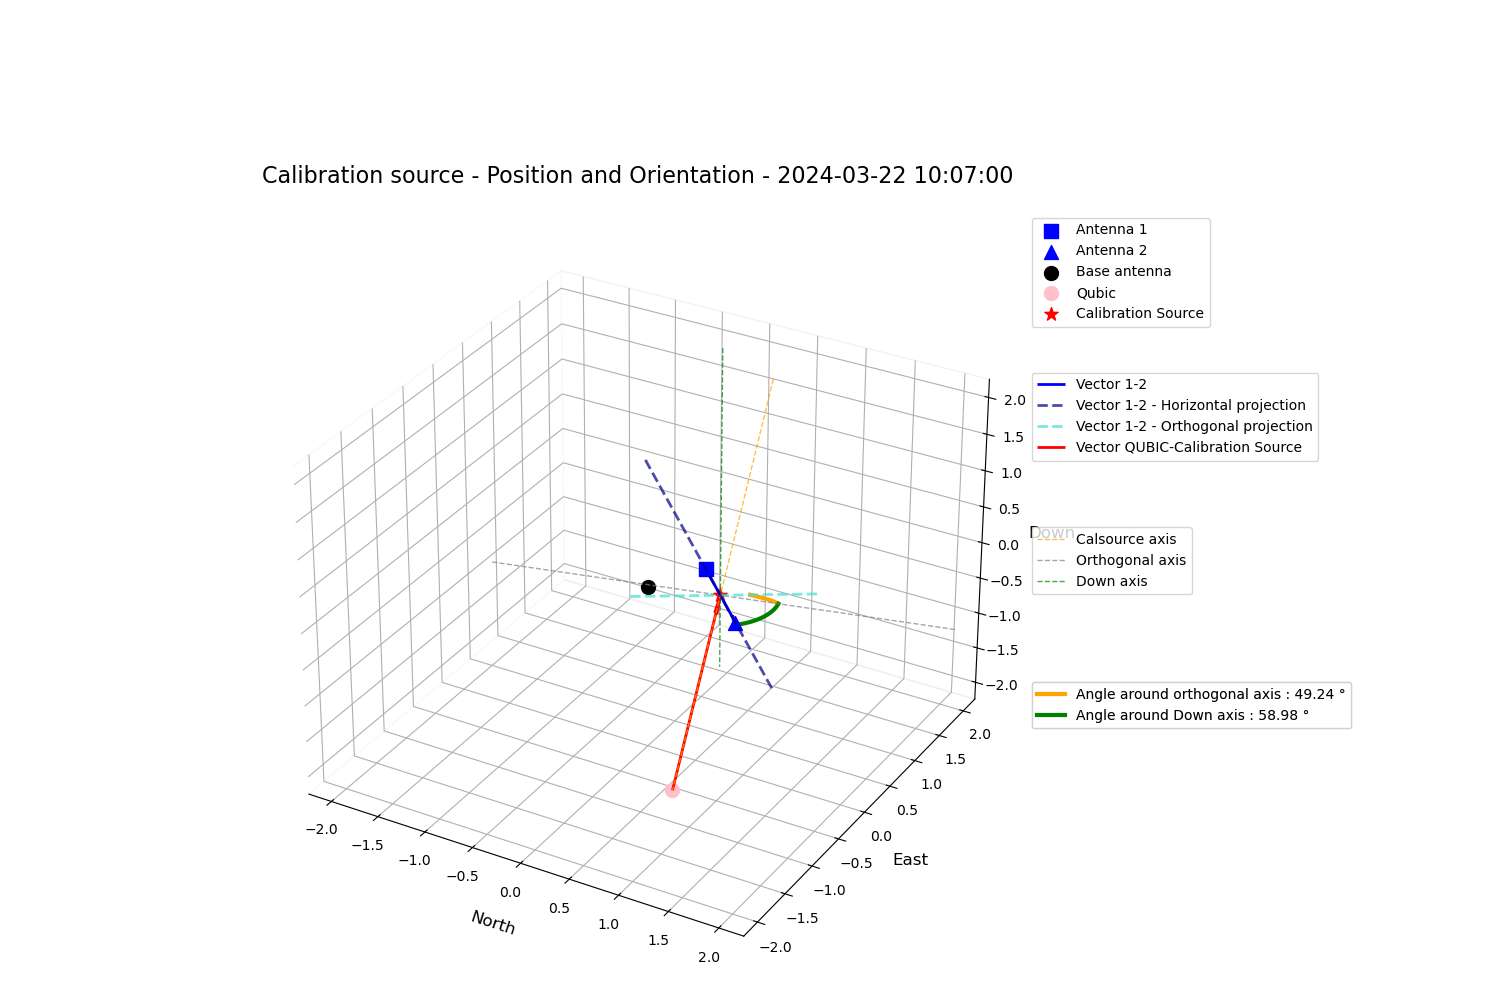

In [4]:
gps.plot_system()

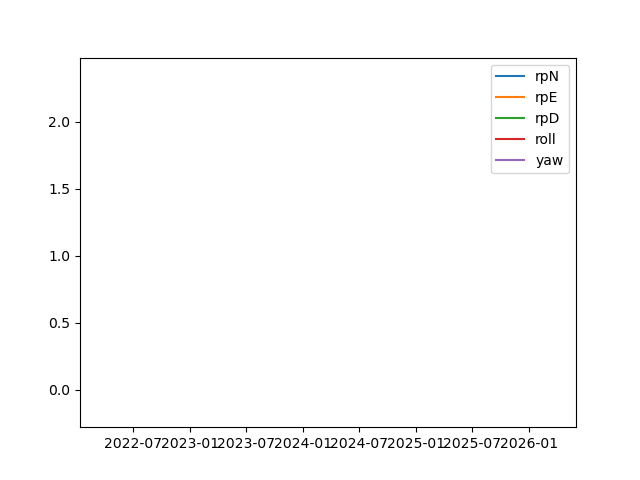

In [5]:
plt.figure()
plt.plot(gps.observation_datetime, gps.rpN, label='rpN')
plt.plot(gps.observation_datetime, gps.rpE, label='rpE')
plt.plot(gps.observation_datetime, gps.rpD, label='rpD')
plt.plot(gps.observation_datetime, gps.roll, label='roll')
plt.plot(gps.observation_datetime, gps.yaw, label='yaw')
plt.legend()

In [6]:
gps.datetime

array([datetime.datetime(2024, 3, 22, 9, 47, 49),
       datetime.datetime(2024, 3, 22, 9, 47, 49, 125000),
       datetime.datetime(2024, 3, 22, 9, 47, 49, 250000), ...,
       datetime.datetime(2024, 3, 22, 16, 13, 49, 250000),
       datetime.datetime(2024, 3, 22, 16, 13, 49, 375000),
       datetime.datetime(2024, 3, 22, 16, 13, 49, 500000)], dtype=object)

In [7]:
idx = gps.get_observation_indices(gps.datetime, np.array([dt.datetime(2024, 3, 22, 10, 7, 00)]))
print(idx)

[9135]


IndexError: index 9135 is out of bounds for axis 0 with size 1

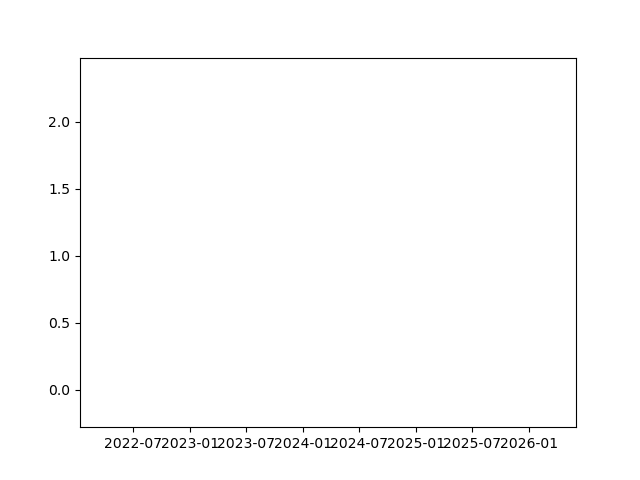

In [8]:
plt.figure()
plt.plot(gps.observation_datetime, gps.rpN, label='rpN')
plt.plot(gps.observation_datetime, gps.rpE, label='rpE')
plt.plot(gps.observation_datetime, gps.rpD, label='rpD')
plt.plot(gps.observation_datetime, gps.roll, label='roll')
plt.plot(gps.observation_datetime, gps.yaw, label='yaw')
plt.vlines(gps.observation_datetime[idx], -5, 6, 'k', label='Chosen observation')
plt.legend()

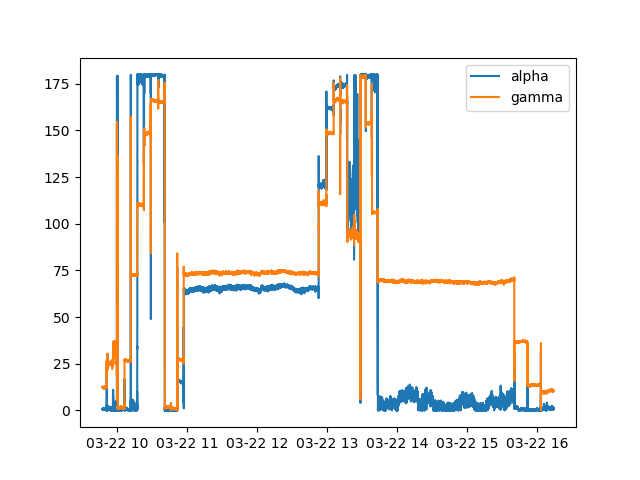

In [ ]:
plt.figure()
plt.plot(gps.observation_datetime, gps.calsource_orientation_angles[0], label='alpha')
plt.plot(gps.observation_datetime, gps.calsource_orientation_angles[2], label='gamma')
plt.legend()

In [ ]:
print('calsource', gps.position_calsource[:, idx])
print('antenna 1', gps.position_antenna1[:, idx])
print('antenna 2', gps.position_antenna2[:, idx])
print('orientation', gps.calsource_orientation_angles[:, idx])

calsource [[0.63367892]
 [0.20247664]
 [0.00063678]]
antenna 1 [[ 2.81857843e-01]
 [ 5.57753274e-01]
 [-2.64498425e-05]]
antenna 2 [[ 0.9855]
 [-0.1528]
 [ 0.0013]]
orientation [[ 0.05735236]
 [ 0.        ]
 [26.99998812]]


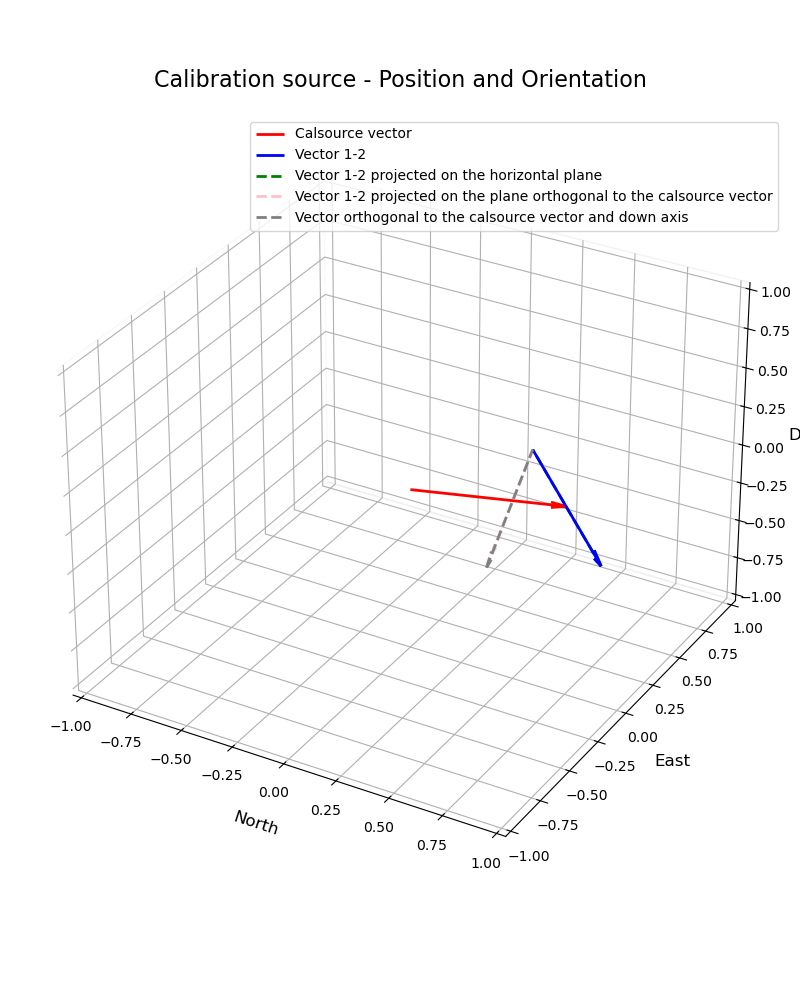

In [ ]:
### Verification of calsource orientation function

fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(111, projection='3d')

# Calsource vector
ax.quiver(gps.base_antenna_position[0], gps.base_antenna_position[1], gps.base_antenna_position[2], 
            gps.vector_calsource[0, idx] - gps.base_antenna_position[0], 
            gps.vector_calsource[1, idx] - gps.base_antenna_position[1], 
            gps.vector_calsource[2, idx] - gps.base_antenna_position[2], 
            color='r', arrow_length_ratio=0.1, linewidth=2, label='Calsource vector')

# Antennas vector
ax.quiver(gps.position_antenna1[0, idx], gps.position_antenna1[1, idx], gps.position_antenna1[2, idx], 
            gps.vector_1_2[0, idx], 
            gps.vector_1_2[1, idx], 
            gps.vector_1_2[2, idx],
            color='b', arrow_length_ratio=0.1, linewidth=2, label='Vector 1-2')

# Antennas vector projected on the horizontal plane
ed = np.array([0, 0, 1])
vector_1_2_ortho_ed = gps.vector_1_2 - (np.sum(gps.vector_1_2 * ed[:, None], axis=0) / np.dot(ed, ed))[None, :] * ed[:, None]
ax.quiver(gps.position_antenna1[0, idx], gps.position_antenna1[1, idx], gps.position_antenna1[2, idx], 
            vector_1_2_ortho_ed[0, idx], 
            vector_1_2_ortho_ed[1, idx], 
            vector_1_2_ortho_ed[2, idx],
            color='g', arrow_length_ratio=0.1, linewidth=2, linestyle='--', label='Vector 1-2 projected on the horizontal plane')

# Antennas vector projected on the plane orthogonal to the calsource vector
n_cal = gps.vector_calsource / np.linalg.norm(gps.vector_calsource)
vector_1_2_ortho_n_cal = gps.vector_1_2 - (np.sum(gps.vector_1_2 * n_cal, axis=0) / np.sum(n_cal * n_cal, axis=0))[None, :] * n_cal
ax.quiver(gps.position_antenna1[0, idx], gps.position_antenna1[1, idx], gps.position_antenna1[2, idx], 
            vector_1_2_ortho_n_cal[0, idx], 
            vector_1_2_ortho_n_cal[1, idx], 
            vector_1_2_ortho_n_cal[2, idx],
            color='pink', arrow_length_ratio=0.1, linewidth=2, linestyle='--', label='Vector 1-2 projected on the plane orthogonal to the calsource vector')

# vector ortho to the calsource vector and down axis
vector_ortho = np.cross(n_cal, ed, axisa=0).T
vector_ortho /= np.linalg.norm(vector_ortho, axis=0)
ax.quiver(gps.position_antenna1[0, idx], gps.position_antenna1[1, idx], gps.position_antenna1[2, idx],
          vector_ortho[0, idx],
          vector_ortho[1, idx],
          vector_ortho[2, idx],
          color='grey', arrow_length_ratio=0.1, linewidth=2, linestyle='--', label='Vector orthogonal to the calsource vector and down axis')

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xlabel('North', fontsize=12, labelpad=10)
ax.set_ylabel('East', fontsize=12, labelpad=10)
ax.set_zlabel('Down', fontsize=12, labelpad=10)

ax.set_title('Calibration source - Position and Orientation', fontsize=16, pad=20)
ax.grid(True, linestyle='--', alpha=0.7)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

plt.legend()
plt.tight_layout()

In [ ]:
def plot_angle_arc(ax, origin, v1, v2, angle, num_points=100, radius=0.5, **kwargs):
    v1_norm = v1 / np.linalg.norm(v1)
    v2_norm = v2 / np.linalg.norm(v2)
    
    # Create orthonormal basis for the plane containing v1 and v2
    normal = np.cross(v1_norm, v2_norm)
    if np.allclose(normal, 0):
        # Vectors are parallel, choose an arbitrary perpendicular vector
        normal = np.array([1, 0, 0]) if np.allclose(v1_norm, [0, 1, 0]) else np.cross(v1_norm, [0, 1, 0])
    normal = normal / np.linalg.norm(normal)
    
    angles = np.linspace(0, angle, num_points)
    arc_points = np.zeros((num_points, 3))
    
    for i, theta in enumerate(angles):
        rotated = v1_norm * np.cos(theta) + \
                 np.cross(normal, v1_norm) * np.sin(theta) + \
                 normal * np.dot(normal, v1_norm) * (1 - np.cos(theta))
        arc_points[i] = origin + radius * rotated
    
    ax.plot(arc_points[:, 0], arc_points[:, 1], arc_points[:, 2], **kwargs)

[ 0.20247664 -0.63367892  0.        ]


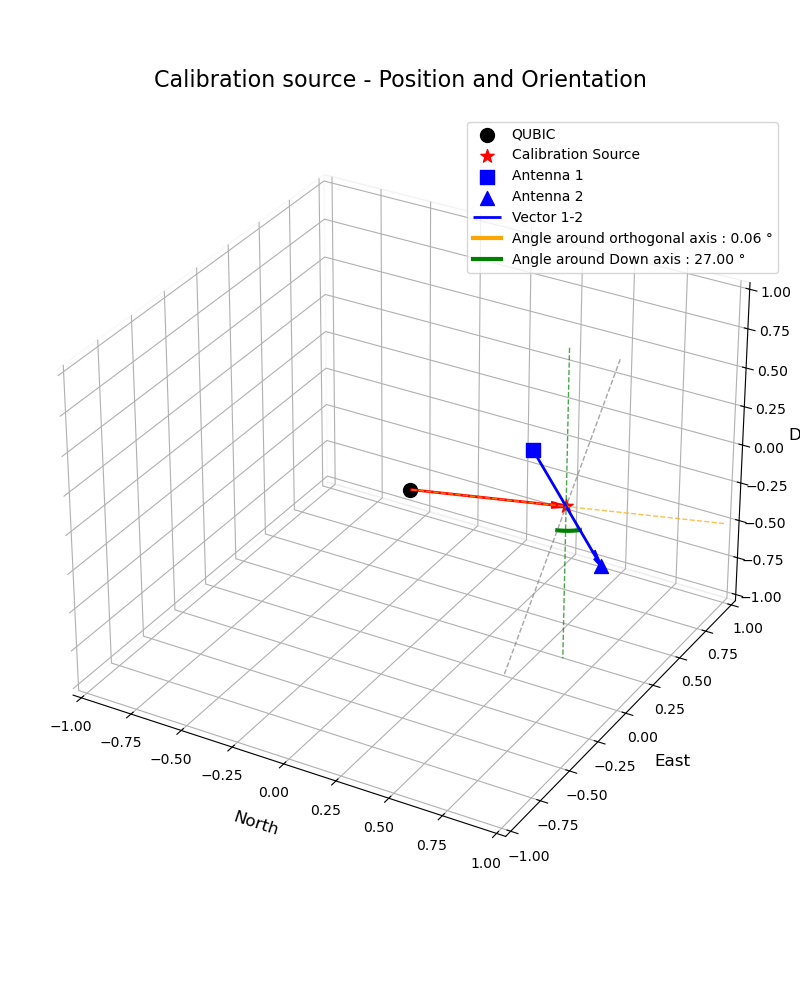

In [ ]:
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(gps.base_antenna_position[0], gps.base_antenna_position[1], gps.base_antenna_position[2], color='k', s=100, label='QUBIC')
ax.scatter(gps.vector_calsource[0, idx], gps.vector_calsource[1, idx], gps.vector_calsource[2, idx], color='r', marker='*', s=100, label='Calibration Source')

ax.quiver(gps.base_antenna_position[0], gps.base_antenna_position[1], gps.base_antenna_position[2], 
            gps.vector_calsource[0, idx] - gps.base_antenna_position[0], 
            gps.vector_calsource[1, idx] - gps.base_antenna_position[1], 
            gps.vector_calsource[2, idx] - gps.base_antenna_position[2], 
            color='r', arrow_length_ratio=0.1, linewidth=2)
ax.quiver(gps.base_antenna_position[0], gps.base_antenna_position[1], gps.base_antenna_position[2], 
            (gps.vector_calsource[0, idx] - gps.base_antenna_position[0])*2, 
            (gps.vector_calsource[1, idx] - gps.base_antenna_position[1])*2, 
            (gps.vector_calsource[2, idx] - gps.base_antenna_position[2])*2, 
            color='orange', arrow_length_ratio=0., linewidth=1, linestyle='--', alpha=0.7)

orth = np.cross(gps.vector_calsource[:, idx][:, 0], np.array([0, 0, 1]))
print(orth)
ax.quiver(gps.vector_calsource[0,idx], gps.vector_calsource[1,idx], gps.vector_calsource[2, idx], 
            (orth[0] - gps.base_antenna_position[0])*2, 
            (orth[1] - gps.base_antenna_position[1])*2, 
            (orth[2] - gps.base_antenna_position[2])*2, 
            color='grey', arrow_length_ratio=0., linewidth=1, linestyle='--', alpha=0.7)
ax.quiver(gps.vector_calsource[0,idx], gps.vector_calsource[1,idx], gps.vector_calsource[2, idx], 
            (orth[0] - gps.base_antenna_position[0])*-2, 
            (orth[1] - gps.base_antenna_position[1])*-2, 
            (orth[2] - gps.base_antenna_position[2])*-2, 
            color='grey', arrow_length_ratio=0., linewidth=1, linestyle='--', alpha=0.7)
ax.quiver(gps.vector_calsource[0,idx], gps.vector_calsource[1,idx], gps.vector_calsource[2, idx] - 1, 
            0, 
            0, 
            2, 
            color='green', arrow_length_ratio=0., linewidth=1, linestyle='--', alpha=0.7)

ax.scatter(gps.position_antenna1[0, idx], gps.position_antenna1[1, idx], gps.position_antenna1[2, idx], color='b', marker='s', s=100, label='Antenna 1')
ax.scatter(gps.position_antenna2[0, idx], gps.position_antenna2[1, idx], gps.position_antenna2[2, idx], color='b', marker='^', s=100, label='Antenna 2')
ax.quiver(gps.position_antenna1[0, idx], gps.position_antenna1[1, idx], gps.position_antenna1[2, idx], 
            gps.position_antenna2[0, idx] - gps.position_antenna1[0, idx], 
            gps.position_antenna2[1, idx] - gps.position_antenna1[1, idx], 
            gps.position_antenna2[2, idx] - gps.position_antenna1[2, idx],
            color='b', arrow_length_ratio=0.1, linewidth=2, label='Vector 1-2')

plot_angle_arc(ax, origin=gps.vector_calsource[:, idx][:, 0], v1=vector_1_2_ortho_n_cal[:, idx][:, 0],
               v2=vector_ortho[:, idx][:, 0], angle=np.radians(gps.calsource_orientation_angles[0, idx][0]), radius=0.2, 
               color='orange', linewidth=3, label = 'Angle around orthogonal axis : {:.2f} °'.format(gps.calsource_orientation_angles[0, idx][0]))
# ax.text(gps.vector_calsource[0,0] - 0.2, gps.vector_calsource[1,0], gps.vector_calsource[2, 0], f'{gps.calsource_orientation_angles[0, 0]:.2f} °',
#         color='orange', fontsize=12, ha='left', va='center')
plot_angle_arc(ax, origin=gps.vector_calsource[:, idx][:, 0], v1=vector_1_2_ortho_ed[:, idx][:, 0], 
               v2=vector_ortho[:, idx][:, 0] - gps.position_antenna2[:, idx][:, 0], angle=np.radians(gps.calsource_orientation_angles[2, idx][0]), radius=0.2, 
               color='green', linewidth=3, label = 'Angle around Down axis : {:.2f} °'.format(gps.calsource_orientation_angles[2, idx][0]))
# ax.text(gps.vector_calsource[0,0] + 0.2, gps.vector_calsource[1,0], gps.vector_calsource[2, 0], f'{gps.calsource_orientation_angles[2, 0]:.2f} °',
#         color='green', fontsize=12, ha='right', va='center')

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xlabel('North', fontsize=12, labelpad=10)
ax.set_ylabel('East', fontsize=12, labelpad=10)
ax.set_zlabel('Down', fontsize=12, labelpad=10)

ax.set_title('Calibration source - Position and Orientation', fontsize=16, pad=20)
ax.grid(True, linestyle='--', alpha=0.7)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

plt.legend()
plt.tight_layout()